# Cálculo de reservas No Vida en Python


En este documento, vamos a tratar de hacer uso de Python para tratar, analizar y calcular reservas de No Vida mediante la aplicación de métodos actuariales en Python.  
  
Ya existen paquetes para facilitar esta labor, como el paquete *chainladder*. Este paquete o modulo es una herramienta muy completa, que incorpora gran cantidad de métodos integrados en sus funciones. Sin embargo, en este documento no vamos a abarcar el uso de esta herramienta (tal vez en el futuro hagamos un recorrido por las funciones que integra).  
  
La finalidad de este documento es acercar el uso de Python al cálculo de reservas en el ámbito de los seguros de No Vida, abarcando algunos los métodos más usados en la industria aseguradora tradicional. Mi único interés es el divulgativo y el de mi propio aprendizaje en el trascurso del desarrollo de este proyecto, dedicando únicamente parte de mi tiempo libre. Por tanto, es posible la presencia (espero que pocos, jeje) de errores tanto técnicos como de programación en este documento.

#### - Carga de modulos.

In [1]:
from base import *

In [2]:
import triangles as tr
import dev_factor as devf
#import base
import tail_factor as tailf
import deterministic as dt
import tests_cl as test

In [3]:
#import ReservMan as resm
#import chain ladder as cl #No se hará uso de esta herramienta en este documento.
import pandas as pd
import numpy as np
from openpyxl import load_workbook
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr


## Importación de datos

Vamos a hacer uso de un dataset que integra ya el paquete *chainladder*, y que recoge datos de siniestralidad de diferentes compañías de seguros en los Estados Unidos para diferentes LoB. 

*https://raw.githubusercontent.com/casact/chainladder-python/master/chainladder/utils/data/clrd.csv*


### - *Desde una base de datos:*


In [4]:
#Lectura de documento .csv
data = pd.read_csv('Data/Claims.csv')

#Información y muestra de los datos importados
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42845 entries, 0 to 42844
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   GRCODE           42845 non-null  int64 
 1   GRNAME           42845 non-null  object
 2   AccidentYear     42845 non-null  int64 
 3   DevelopmentYear  42845 non-null  int64 
 4   DevelopmentLag   42845 non-null  int64 
 5   IncurLoss        42845 non-null  int64 
 6   CumPaidLoss      42845 non-null  int64 
 7   BulkLoss         42845 non-null  int64 
 8   EarnedPremDIR    42845 non-null  int64 
 9   EarnedPremCeded  42845 non-null  int64 
 10  EarnedPremNet    42845 non-null  int64 
 11  Single           42845 non-null  int64 
 12  PostedReserve97  42845 non-null  int64 
 13  LOB              42845 non-null  object
dtypes: int64(12), object(2)
memory usage: 4.6+ MB


,GRCODE,GRNAME,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss,CumPaidLoss,BulkLoss,EarnedPremDIR,EarnedPremCeded,EarnedPremNet,Single,PostedReserve97,LOB
0,86,Allstate Ins Co Grp,1988,1988,1,367404,70571,127737,400699,5957,394742,0,281872,wkcomp
1,86,Allstate Ins Co Grp,1988,1989,2,362988,155905,60173,400699,5957,394742,0,281872,wkcomp
2,86,Allstate Ins Co Grp,1988,1990,3,347288,220744,27763,400699,5957,394742,0,281872,wkcomp
3,86,Allstate Ins Co Grp,1988,1991,4,330648,251595,15280,400699,5957,394742,0,281872,wkcomp
4,86,Allstate Ins Co Grp,1988,1992,5,354690,274156,27689,400699,5957,394742,0,281872,wkcomp


Los datos que nos van a interesar para nuestro análisis son:
- **AccidentYear:** Año de accidente de los siniestros.
- **DevelopmentYear:** Año de desarrollo.
- **DevelopmentLag:** Periodo de desarrollo medido como *DevelopmentYear - AccidentYear + 1.
- **IncurLoss:** Coste incurrido de los siniestros ocurridos en un año de accidente dado para cada año de desarrollo (Coste incurrido = Pagos acumulados + Reservas caso a caso).
- **CumPaidLoss:** Pagos acumulados de los siniestros ocurridos en un año de accidente dado para cada año de desarrollo.
- **EarnedPremDIR:** Prima imputada del seguro directo en cada año de accidente. (También se puede conocer como prima ganada por su traducción directa del inglés).

A continuación, se van a contruir, a partir de esta bbdd los triángulos para pagos acumulados y coste incurrido para las LoB de *ppauto* y *othliab*. Incluiremos los datos de todas las compañías, ya que al tratarse de un trabajo ilustrativo, dispondremos de un volumen mayor de datos.


In [5]:
#Triángulos de LoB ppauto
triang_CumPaid_ppauto = upload_triangle_from_csv(file='Data/Claims.csv', 
                                                 base_period='AccidentYear', 
                                                 dev_period='DevelopmentLag', 
                                                 aggr_values='CumPaidLoss', 
                                                 lob_column='LOB', 
                                                 lob_name='ppauto', 
                                                 type_triangle='CumPayments')

triang_IncLoss_ppauto = upload_triangle_from_csv('Data/Claims.csv', 'AccidentYear', 'DevelopmentLag', 'IncurLoss', 'LOB', 'ppauto', 'Incurred')

#Triángulos de LoB othliab
triang_CumPaid_othliab = upload_triangle_from_csv('Data/Claims.csv', 'AccidentYear', 'DevelopmentLag', 'CumPaidLoss', 'LOB', 'othliab', 'CumPayments')
triang_IncLoss_othliab = upload_triangle_from_csv('Data/Claims.csv', 'AccidentYear', 'DevelopmentLag', 'IncurLoss', 'LOB', 'othliab', 'Incurred')

#Muestra del Output:
triang_CumPaid_ppauto.show()

h:\Mi unidad\paquete_reserving_python\base.py:225: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_df = self.input_triangle.applymap(lambda x: "{:,.2f}".format(x))


DevelopmentLag,1,2,3,4,5,6,7,8,9,10
AccidentYear,,,,,,,,,,
1988,"3,092,818.00","5,942,711.00","7,239,089.00","7,930,109.00","8,318,795.00","8,518,201.00","8,610,355.00","8,655,509.00","8,682,451.00","8,690,036.00"
1989,"3,556,683.00","6,753,435.00","8,219,551.00","9,018,288.00","9,441,842.00","9,647,917.00","9,753,014.00","9,800,477.00","9,823,747.00",nan
1990,"4,015,052.00","7,478,257.00","9,094,949.00","9,945,288.00","10,371,175.00","10,575,467.00","10,671,988.00","10,728,411.00",nan,nan
1991,"4,065,571.00","7,564,284.00","9,161,104.00","10,006,407.00","10,419,901.00","10,612,083.00","10,713,621.00",nan,nan,nan
1992,"4,551,591.00","8,344,021.00","10,047,179.00","10,901,995.00","11,336,777.00","11,555,121.00",nan,nan,nan,nan
1993,"5,020,277.00","9,125,734.00","10,890,282.00","11,782,219.00","12,249,826.00",nan,nan,nan,nan,nan
1994,"5,569,355.00","9,871,002.00","11,641,397.00","12,600,432.00",nan,nan,nan,nan,nan,nan
1995,"5,803,124.00","10,008,734.00","11,807,279.00",nan,nan,nan,nan,nan,nan,nan
1996,"5,835,368.00","9,900,842.00",nan,nan,nan,nan,nan,nan,nan,nan


### *- Desde un triángulo en fichero excel:*
Se muestra a continuación la lectura del primero de los triángulos, a modo ilustrativo, en caso que se dispusiera del triángulo construido en un fichero .xlsx:

In [6]:
## TRIÁNGULO PAGOS ACUMULADOS

triang_CumPaid_ppauto = upload_triangle_from_excel(file = "Data/Triangles.xlsx", 
                                                 sheet = "0_Datos de entrada", 
                                                 init_col = 3, 
                                                 init_row = 12, 
                                                 dim = 14, 
                                                 start_year=2008,
                                                 month=12,
                                                 periodicity='annual',
                                                 type_triangle='CumPayments')
triang_CumPaid_ppauto.show()



h:\Mi unidad\paquete_reserving_python\base.py:225: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_df = self.input_triangle.applymap(lambda x: "{:,.2f}".format(x))


,1,2,3,4,5,6,7,8,9,10,11,12,13,14
AccidentYear,,,,,,,,,,,,,,
12/2008,"59,769,792.25","165,450,290.25","199,870,725.25","217,710,186.75","226,508,362.50","231,561,596.00","234,583,184.50","235,492,526.50","235,842,953.50","236,679,451.75","236,830,634.25","237,088,328.75","237,137,708.50","237,139,707.00"
12/2009,"66,322,949.00","172,599,974.75","202,734,288.75","219,299,874.50","229,098,212.00","233,612,156.75","235,362,048.25","236,241,391.75","236,582,442.25","236,978,784.00","237,011,082.00","237,220,333.00","237,241,838.75",nan
12/2010,"65,872,992.50","171,545,542.00","204,518,830.25","219,677,340.75","228,315,913.00","230,619,957.75","232,128,895.25","233,760,436.00","234,838,481.50","235,400,644.50","235,481,167.25","236,568,641.75",nan,nan
12/2011,"73,281,092.50","177,437,692.25","211,989,349.25","225,904,938.00","233,299,603.25","237,212,167.50","238,171,038.00","238,204,519.00","239,276,107.00","239,329,410.25","239,647,219.00",nan,nan,nan
12/2012,"71,133,350.75","170,462,076.75","202,128,321.50","215,426,247.75","220,361,960.00","223,714,366.75","224,830,359.25","225,441,690.25","225,710,275.00","225,835,380.75",nan,nan,nan,nan
12/2013,"73,052,085.75","169,312,321.50","196,125,924.75","205,648,105.25","209,351,135.00","210,680,426.25","212,484,079.50","213,326,428.00","213,720,710.00",nan,nan,nan,nan,nan
12/2014,"80,029,486.25","167,411,221.25","191,426,151.00","202,659,814.00","207,440,765.00","209,990,095.00","211,954,827.00","213,343,348.75",nan,nan,nan,nan,nan,nan
12/2015,"79,283,232.00","163,188,432.75","194,775,049.00","213,604,716.50","221,803,863.75","226,107,304.50","228,078,954.25",nan,nan,nan,nan,nan,nan,nan
12/2016,"76,831,315.75","149,990,867.25","176,481,879.00","194,354,543.25","203,591,533.25","207,264,256.50",nan,nan,nan,nan,nan,nan,nan,nan


In [7]:
## TRIÁNGULO DE INCURRIDO

triang_Incurred_ppauto = upload_triangle_from_excel(file = "Data/Triangles.xlsx", 
                                                 sheet = "0_Datos de entrada", 
                                                 init_col = 3, 
                                                 init_row = 46, 
                                                 dim = 14, 
                                                 start_year=2008,
                                                 month=12,
                                                 periodicity='annual',
                                                 type_triangle='Incurred')
triang_Incurred_ppauto.show()

h:\Mi unidad\paquete_reserving_python\base.py:225: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_df = self.input_triangle.applymap(lambda x: "{:,.2f}".format(x))


,1,2,3,4,5,6,7,8,9,10,11,12,13,14
AccidentYear,,,,,,,,,,,,,,
12/2008,"160,139,045.50","226,559,737.25","236,266,268.00","244,960,152.50","243,214,489.00","242,232,361.00","237,986,488.25","237,402,737.25","237,520,052.00","237,846,378.00","237,655,232.50","237,107,363.50","237,137,708.50","237,139,707.00"
12/2009,"170,668,596.00","229,474,322.00","241,053,886.50","247,883,002.50","246,231,580.00","242,918,107.25","241,458,780.50","240,670,060.75","240,441,831.00","238,746,816.00","238,458,078.25","238,656,180.00","238,669,835.25",nan
12/2010,"172,718,677.25","231,355,591.25","243,742,133.25","244,439,980.75","241,871,707.00","240,849,518.00","239,921,955.00","239,826,406.75","239,671,876.50","239,397,733.75","238,663,761.00","237,407,042.25",nan,nan
12/2011,"183,979,363.75","241,276,966.00","249,143,599.25","249,556,895.00","247,601,653.25","244,683,960.50","243,566,232.00","243,056,439.50","241,679,172.00","242,572,099.00","243,090,398.25",nan,nan,nan
12/2012,"175,627,597.25","226,648,257.50","238,413,819.00","234,372,948.25","232,489,365.50","228,558,839.25","227,516,628.50","226,527,089.25","226,508,345.00","226,246,170.50",nan,nan,nan,nan
12/2013,"177,484,462.75","223,476,284.50","223,127,831.50","221,309,161.50","219,625,833.00","217,998,572.75","219,304,239.00","218,348,907.00","218,296,573.25",nan,nan,nan,nan,nan
12/2014,"192,433,529.75","224,730,010.75","226,156,647.50","222,911,496.50","221,214,136.50","221,192,476.75","220,667,758.50","219,193,220.75",nan,nan,nan,nan,nan,nan
12/2015,"195,675,030.25","248,325,743.75","250,155,328.50","243,339,946.50","240,425,484.25","237,945,648.50","239,437,836.75",nan,nan,nan,nan,nan,nan,nan
12/2016,"195,320,417.25","231,643,347.25","237,312,493.25","235,702,867.75","232,689,189.25","234,761,751.00",nan,nan,nan,nan,nan,nan,nan,nan


In [8]:
## TRIANGULO DE RESERVA CASO A CASO

triang_Reserve_ppauto = upload_triangle_from_excel(file = "Data/Triangles.xlsx", 
                                                 sheet = "0_Datos de entrada", 
                                                 init_col = 3, 
                                                 init_row = 29, 
                                                 dim = 14, 
                                                 start_year=2008,
                                                 month=12,
                                                 periodicity='annual',
                                                 type_triangle='CaseReserves')
triang_Reserve_ppauto.show()

h:\Mi unidad\paquete_reserving_python\base.py:225: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_df = self.input_triangle.applymap(lambda x: "{:,.2f}".format(x))


,1,2,3,4,5,6,7,8,9,10,11,12,13,14
AccidentYear,,,,,,,,,,,,,,
12/2008,"100,369,253.25","61,109,447.00","36,395,542.75","27,249,965.75","16,706,126.50","10,670,765.00","3,403,303.75","1,910,210.75","1,677,098.50","1,166,926.25","824,598.25","19,034.75",0.00,0.00
12/2009,"104,345,647.00","56,874,347.25","38,319,597.75","28,583,128.00","17,133,368.00","9,305,950.50","6,096,732.25","4,428,669.00","3,859,388.75","1,768,032.00","1,446,996.25","1,435,847.00","1,427,996.50",nan
12/2010,"106,845,684.75","59,810,049.25","39,223,303.00","24,762,640.00","13,555,794.00","10,229,560.25","7,793,059.75","6,065,970.75","4,833,395.00","3,997,089.25","3,182,593.75","838,400.50",nan,nan
12/2011,"110,698,271.25","63,839,273.75","37,154,250.00","23,651,957.00","14,302,050.00","7,471,793.00","5,395,194.00","4,851,920.50","2,403,065.00","3,242,688.75","3,443,179.25",nan,nan,nan
12/2012,"104,494,246.50","56,186,180.75","36,285,497.50","18,946,700.50","12,127,405.50","4,844,472.50","2,686,269.25","1,085,399.00","798,070.00","410,789.75",nan,nan,nan,nan
12/2013,"104,432,377.00","54,163,963.00","27,001,906.75","15,661,056.25","10,274,698.00","7,318,146.50","6,820,159.50","5,022,479.00","4,575,863.25",nan,nan,nan,nan,nan
12/2014,"112,404,043.50","57,318,789.50","34,730,496.50","20,251,682.50","13,773,371.50","11,202,381.75","8,712,931.50","5,849,872.00",nan,nan,nan,nan,nan,nan
12/2015,"116,391,798.25","85,137,311.00","55,380,279.50","29,735,230.00","18,621,620.50","11,838,344.00","11,358,882.50",nan,nan,nan,nan,nan,nan,nan
12/2016,"118,489,101.50","81,652,480.00","60,830,614.25","41,348,324.50","29,097,656.00","27,497,494.50",nan,nan,nan,nan,nan,nan,nan,nan


#### Asignación de nuevos nombres:

In [9]:
CumPaid_tr = triang_CumPaid_ppauto
Incurred_tr = triang_Incurred_ppauto
CaseRes_tr = triang_Reserve_ppauto

In [10]:
Incurred_tr.show()

h:\Mi unidad\paquete_reserving_python\base.py:225: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_df = self.input_triangle.applymap(lambda x: "{:,.2f}".format(x))


,1,2,3,4,5,6,7,8,9,10,11,12,13,14
AccidentYear,,,,,,,,,,,,,,
12/2008,"160,139,045.50","226,559,737.25","236,266,268.00","244,960,152.50","243,214,489.00","242,232,361.00","237,986,488.25","237,402,737.25","237,520,052.00","237,846,378.00","237,655,232.50","237,107,363.50","237,137,708.50","237,139,707.00"
12/2009,"170,668,596.00","229,474,322.00","241,053,886.50","247,883,002.50","246,231,580.00","242,918,107.25","241,458,780.50","240,670,060.75","240,441,831.00","238,746,816.00","238,458,078.25","238,656,180.00","238,669,835.25",nan
12/2010,"172,718,677.25","231,355,591.25","243,742,133.25","244,439,980.75","241,871,707.00","240,849,518.00","239,921,955.00","239,826,406.75","239,671,876.50","239,397,733.75","238,663,761.00","237,407,042.25",nan,nan
12/2011,"183,979,363.75","241,276,966.00","249,143,599.25","249,556,895.00","247,601,653.25","244,683,960.50","243,566,232.00","243,056,439.50","241,679,172.00","242,572,099.00","243,090,398.25",nan,nan,nan
12/2012,"175,627,597.25","226,648,257.50","238,413,819.00","234,372,948.25","232,489,365.50","228,558,839.25","227,516,628.50","226,527,089.25","226,508,345.00","226,246,170.50",nan,nan,nan,nan
12/2013,"177,484,462.75","223,476,284.50","223,127,831.50","221,309,161.50","219,625,833.00","217,998,572.75","219,304,239.00","218,348,907.00","218,296,573.25",nan,nan,nan,nan,nan
12/2014,"192,433,529.75","224,730,010.75","226,156,647.50","222,911,496.50","221,214,136.50","221,192,476.75","220,667,758.50","219,193,220.75",nan,nan,nan,nan,nan,nan
12/2015,"195,675,030.25","248,325,743.75","250,155,328.50","243,339,946.50","240,425,484.25","237,945,648.50","239,437,836.75",nan,nan,nan,nan,nan,nan,nan
12/2016,"195,320,417.25","231,643,347.25","237,312,493.25","235,702,867.75","232,689,189.25","234,761,751.00",nan,nan,nan,nan,nan,nan,nan,nan


In [11]:
Incurred_tr.show()

h:\Mi unidad\paquete_reserving_python\base.py:225: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_df = self.input_triangle.applymap(lambda x: "{:,.2f}".format(x))


,1,2,3,4,5,6,7,8,9,10,11,12,13,14
AccidentYear,,,,,,,,,,,,,,
12/2008,"160,139,045.50","226,559,737.25","236,266,268.00","244,960,152.50","243,214,489.00","242,232,361.00","237,986,488.25","237,402,737.25","237,520,052.00","237,846,378.00","237,655,232.50","237,107,363.50","237,137,708.50","237,139,707.00"
12/2009,"170,668,596.00","229,474,322.00","241,053,886.50","247,883,002.50","246,231,580.00","242,918,107.25","241,458,780.50","240,670,060.75","240,441,831.00","238,746,816.00","238,458,078.25","238,656,180.00","238,669,835.25",nan
12/2010,"172,718,677.25","231,355,591.25","243,742,133.25","244,439,980.75","241,871,707.00","240,849,518.00","239,921,955.00","239,826,406.75","239,671,876.50","239,397,733.75","238,663,761.00","237,407,042.25",nan,nan
12/2011,"183,979,363.75","241,276,966.00","249,143,599.25","249,556,895.00","247,601,653.25","244,683,960.50","243,566,232.00","243,056,439.50","241,679,172.00","242,572,099.00","243,090,398.25",nan,nan,nan
12/2012,"175,627,597.25","226,648,257.50","238,413,819.00","234,372,948.25","232,489,365.50","228,558,839.25","227,516,628.50","226,527,089.25","226,508,345.00","226,246,170.50",nan,nan,nan,nan
12/2013,"177,484,462.75","223,476,284.50","223,127,831.50","221,309,161.50","219,625,833.00","217,998,572.75","219,304,239.00","218,348,907.00","218,296,573.25",nan,nan,nan,nan,nan
12/2014,"192,433,529.75","224,730,010.75","226,156,647.50","222,911,496.50","221,214,136.50","221,192,476.75","220,667,758.50","219,193,220.75",nan,nan,nan,nan,nan,nan
12/2015,"195,675,030.25","248,325,743.75","250,155,328.50","243,339,946.50","240,425,484.25","237,945,648.50","239,437,836.75",nan,nan,nan,nan,nan,nan,nan
12/2016,"195,320,417.25","231,643,347.25","237,312,493.25","235,702,867.75","232,689,189.25","234,761,751.00",nan,nan,nan,nan,nan,nan,nan,nan


## Análisis de los datos:
### Triángulo de pagos acumulado
Antes de llevar a cabo ninguna proyección, es una buena opción, y más en Python, poder hacer una análisis visual del triángulo. 

Para mostrar los gráficos, usaremos la libería *plotly.express*, si bien se pueden usar otras con un diseño más atractivo, nos decantamos por esta porque nos permite un análisis del gráfico de forma más interactiva.

A continuación veremos de forma gráfica el desarrollo de los pagos acumulados por **año de accidente:**

In [12]:
#Grafico por año de accidente y año de desarrollo del triangulo de pagos acumulados:
CumPaid_tr.graph_tr()

### Triángulo de costes incurridos

In [13]:
#Grafico por año de accidente y año de desarrollo del triangulo de Coste Incurrido:
Incurred_tr.graph_tr()

Como se observa en el gráfico anterior, los pagos de este triángulo se desarrollan de forma creciente, sin observar recobros en ningún periodo de desarrollo.

### Triángulo de pagos incremental
Al igual que se ha analizado el triángulo de pagos acumulado, también se podría hacer lo mismo con el triángulo de pagos incremental.

Si bien puede que no dispongamos directamente de él (o viceversa), se crean dos funciones, una para el paso de un triángulo de pagos incrementales a acumulados, y otra para el paso de triángulos acumulados a incrementales. Esta última función la aplicaremos a continución para obtener una triángulo incremental que podamos analizar.

Con las funciones de transformación creadas, podremos obtener de forma simple el triángulo de pagos incremental que podríamos analizar.

In [14]:
triang_IncrPaid_ppauto = CumPaid_tr.to_incr()
triang_IncrPaid_ppauto.show()

h:\Mi unidad\paquete_reserving_python\base.py:225: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,1,2,3,4,5,6,7,8,9,10,11,12,13,14
AccidentYear,,,,,,,,,,,,,,
12/2008,"59,769,792.25","105,680,498.00","34,420,435.00","17,839,461.50","8,798,175.75","5,053,233.50","3,021,588.50","909,342.00","350,427.00","836,498.25","151,182.50","257,694.50","49,379.75","1,998.50"
12/2009,"66,322,949.00","106,277,025.75","30,134,314.00","16,565,585.75","9,798,337.50","4,513,944.75","1,749,891.50","879,343.50","341,050.50","396,341.75","32,298.00","209,251.00","21,505.75",nan
12/2010,"65,872,992.50","105,672,549.50","32,973,288.25","15,158,510.50","8,638,572.25","2,304,044.75","1,508,937.50","1,631,540.75","1,078,045.50","562,163.00","80,522.75","1,087,474.50",nan,nan
12/2011,"73,281,092.50","104,156,599.75","34,551,657.00","13,915,588.75","7,394,665.25","3,912,564.25","958,870.50","33,481.00","1,071,588.00","53,303.25","317,808.75",nan,nan,nan
12/2012,"71,133,350.75","99,328,726.00","31,666,244.75","13,297,926.25","4,935,712.25","3,352,406.75","1,115,992.50","611,331.00","268,584.75","125,105.75",nan,nan,nan,nan
12/2013,"73,052,085.75","96,260,235.75","26,813,603.25","9,522,180.50","3,703,029.75","1,329,291.25","1,803,653.25","842,348.50","394,282.00",nan,nan,nan,nan,nan
12/2014,"80,029,486.25","87,381,735.00","24,014,929.75","11,233,663.00","4,780,951.00","2,549,330.00","1,964,732.00","1,388,521.75",nan,nan,nan,nan,nan,nan
12/2015,"79,283,232.00","83,905,200.75","31,586,616.25","18,829,667.50","8,199,147.25","4,303,440.75","1,971,649.75",nan,nan,nan,nan,nan,nan,nan
12/2016,"76,831,315.75","73,159,551.50","26,491,011.75","17,872,664.25","9,236,990.00","3,672,723.25",nan,nan,nan,nan,nan,nan,nan,nan


In [15]:
# Asignamos el nuevo triangulo a su clase correspondiente:
IncPaid_tr = CumPaid_tr.to_incr()

In [16]:
#Grafico por año de accidente y año de desarrollo del triangulo de Pagos incremental:
IncPaid_tr.graph_tr()

### Factores de paso
Creamos una función para el cálculo de los factores de paso, que también nos servirá en el futuro para cualquier otro triángulo.

Aplicamos la función para obtener los factores de paso sobre el triángulo de coste incurrido:

In [17]:
linkf_incurred = Incurred_tr.link_factors()
linkf_incurred

,1,2,3,4,5,6,7,8,9,10,11,12,13
AccidentYear,,,,,,,,,,,,,
12/2008,1.414769,1.042843,1.036797,0.992874,0.995962,0.982472,0.997547,1.000494,1.001374,0.999196,0.997695,1.000128,1.000008
12/2009,1.344561,1.050461,1.028330,0.993338,0.986543,0.993993,0.996734,0.999052,0.992950,0.998791,1.000831,1.000057,NaN
12/2010,1.339494,1.053539,1.002863,0.989493,0.995774,0.996149,0.999602,0.999356,0.998856,0.996934,0.994734,NaN,NaN
12/2011,1.311435,1.032604,1.001659,0.992165,0.988216,0.995432,0.997907,0.994334,1.003695,1.002137,NaN,NaN,NaN
12/2012,1.290505,1.051911,0.983051,0.991963,0.983094,0.995440,0.995651,0.999917,0.998843,NaN,NaN,NaN,NaN
12/2013,1.259132,0.998441,0.991849,0.992394,0.992591,1.005989,0.995644,0.999760,NaN,NaN,NaN,NaN,NaN
12/2014,1.167832,1.006348,0.985651,0.992385,0.999902,0.997628,0.993318,NaN,NaN,NaN,NaN,NaN,NaN
12/2015,1.269072,1.007368,0.972755,0.988023,0.989686,1.006271,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12/2016,1.185966,1.024474,0.993217,0.987214,1.008907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Para una mejor interpretación de la matriz de factores, podemos aplicarle un mapa de calor:

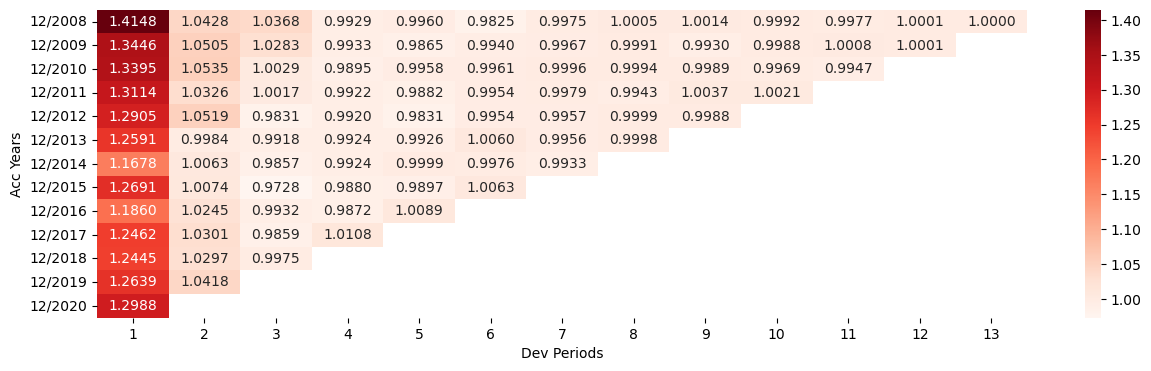

In [18]:
# Ultilizamos la libreria de seaborn para mostrar de forma más visual los factores de paso
Incurred_tr.heatmap_linkf()

In [19]:
# Gráfico por año de accidente de los Link factors:
Incurred_tr.graph_linkf()


### Factores de desarrollo

A continuación creamos los factores de desarrollo, mediante la metodología Chain-Ladder, ampliamente usada en la industria aseguradora, mediante el cálculo de un desarrollo por promedio ponderado o Weight-Average. 

En este momento, vamos a llevar a cabo un cálculo rápido sin ignorar factores, más adelante mostraremos cómo ignorar factores de paso, y cómo estimar el factor de desarrollo mediante otra formulación.

In [20]:
Incurred_tr.get_dev_f(method='vol_weight', cal_y_ignore=0, acc_y_ignore=0, f_ignore=None)

dev_f([1.2759893 , 1.03084414, 0.99809336, 0.99310963, 0.99330834,
       0.99652545, 0.99668968, 0.99878094, 0.99914652, 0.99927438,
       0.99775247, 1.00009248, 1.00000843])

In [21]:
incurred_df = Incurred_tr.get_dev_f(method='vol_weight', cal_y_ignore=0, acc_y_ignore=0, f_ignore=None)

In [22]:
CumPaid_df = CumPaid_tr.get_dev_f(method='vol_weight', cal_y_ignore=0, acc_y_ignore=0, f_ignore=None)
CumPaid_df

dev_f([2.25041973, 1.18401686, 1.07833649, 1.03526378, 1.01565382,
       1.00781554, 1.0039609 , 1.00253458, 1.00168344, 1.00061347,
       1.00219141, 1.00014945, 1.00000843])

In [23]:
Incurred_tr.get_dev_f(method='vol_weight', cal_y_ignore=0, acc_y_ignore=0, f_ignore=None).graph_df()

A parte de esta metodología, que es la más usada, para obtener los factores de desarrollo, existen otras metodologías. Aquí vamos a formularlas, incluyendo la opción de ignorar factores de paso, bien por año de calendario o por año de accidente.

En primer lugar, vamos a contruir una función que devuelva un triángulo con los pesos que se quiera dar a cada uno de los factores de paso. Los valores serán 1 o 0 en función de si deseamos tener esos factores de paso en cuenta o no.

En el ejemplo de uso de la función, creamos unos pesos que ignoren los cuatro primeros años de calendario y el primer año de accidente.

Una vez definida un triángulo que contenga los pesos que queremos otorgar a cada factor de paso, podremos crear una función que permita calcular los factores de desarrollo mediante distintas metodologías y con la opción de poder ignorar diferentes factores.

Las distintas metodologías que incorporaremos son:
- **Simple average:** Media aritmetica de los factores de paso. *(avg)*
- **Volume Weighted average:** Media ponderada de los factores por el importe de los siniestros (otorgando mayor ponderación a los factores con una mayor siniestralidad). *(vol_weight)*
- **Time Weighted average:** Media ponderada de los factores, dando mayor peso a los factores más recientes frente a periodos más antiguos. *(time_weight)*
- **Median:** Mediana de los factores de paso. *(median)*
- **Geometric average:** *(geom_avg)*
- **Medial average:** Media aritmetica, ignorando los factores máximos y mínimos. *(medial_avg)*
- **Min.:** Valor del factor mínimo. *(min)*
- **Max.:** Valor del factor máximo. *(max)*

Dentro de los inputs de la función se podrán incorporar también los periodos de calendario y/o de accidente que se desean ignorar del cálculo.

Con las funciones creadas anteriores, se puede ver rapidamente una comparativa de los factores de desarrollo resultantes en cada caso:

In [24]:
Incurred_tr.get_dev_f(method='all', cal_y_ignore=0, acc_y_ignore=0, f_ignore=None)

dev_f([[1.27970479, 1.2759893 , 1.25911133, 1.26907221, 1.27814917,
        1.27759651, 1.16783188, 1.41476888],
       [1.03079989, 1.03084414, 1.02741191, 1.03133422, 1.03064324,
        1.0317619 , 0.99844076, 1.05353898],
       [0.99813735, 0.99809336, 0.99130955, 0.99321727, 0.99797142,
        0.99666205, 0.9727554 , 1.03679698],
       [0.99306513, 0.99310963, 0.99408536, 0.99227532, 0.99304566,
        0.99157945, 0.98721408, 1.01080158],
       [0.99340827, 0.99330834, 0.99504912, 0.99259076, 0.99338098,
        0.99266767, 0.98309374, 1.008907  ],
       [0.99667168, 0.99652545, 0.99964808, 0.99579443, 0.99664705,
        0.99743841, 0.9824719 , 1.00627113],
       [0.99662881, 0.99668968, 0.99595673, 0.99673352, 0.99662708,
        0.99669642, 0.99331784, 0.99960175],
       [0.99881877, 0.99878094, 0.99867366, 0.99955799, 0.99881665,
        0.99952123, 0.99433355, 1.00049416],
       [0.99914354, 0.99914652, 0.99952231, 0.99885617, 0.9991371 ,
        0.99969087, 0.992950

In [25]:
Incurred_tr.get_dev_f(method='all', cal_y_ignore=0, acc_y_ignore=0, f_ignore=None).graph_df()

A continuación tomamos la media ponderada *volume weight* como los factores de desarrollo que usaremos e nuestro análisis.

In [26]:
Factors_to_ignore = [('12/2014', 1), ('12/2016', 1), ('12/2013', 2)]

In [27]:
df_incurred = Incurred_tr.get_dev_f(method='vol_weight', cal_y_ignore=0, acc_y_ignore=0, f_ignore=Factors_to_ignore)
df_incurred

dev_f([1.29551492, 1.03362726, 0.99809336, 0.99310963, 0.99330834,
       0.99652545, 0.99668968, 0.99878094, 0.99914652, 0.99927438,
       0.99775247, 1.00009248, 1.00000843])

Junto con los factores de desarrollo, es interesante revisar el producto de los factores de desarrollo, que nos muestra el acumulado de los factores de desarrollo. También se puede análizar cómo de desarrollado se encuentra el triángulo en cada caso mediante el inverso del producto de los factores de desarrollo. Conocer si el triángulo está muy desarrollado o no puede ser bastante últil a la hora de elegir que metodología es la más apropiada o no. Más adelante veremos esto con más detenimiento.

In [28]:
df_incurred.cdf()

[1.3030407096526313,
 1.0058091069747748,
 0.9730868588597307,
 0.9749457298937636,
 0.9817100791901537,
 0.9883236015620764,
 0.9917695497808868,
 0.9950635295057482,
 0.9962780505467228,
 0.9971290840671657,
 0.997853150690959,
 1.0001009118138537,
 1.0000084275926113]

In [29]:
df_incurred.inv_df()

[0.7674357313568377,
 0.9942244438487466,
 1.0276574911018799,
 1.0256981176880138,
 1.0186306743686835,
 1.0118143474662233,
 1.0082987526900091,
 1.0049609601275447,
 1.0037358541134522,
 1.0028791818218,
 1.0021514681870318,
 0.9998990983683129,
 0.9999915724784124]

### Factor cola

En ciertos casos, podemos presenciar triángulos en los que, bien porque se trate de un negocio de desarrollo lento (como pudieran ser seguros de RC Corporal en los seguros de auto), o bien porque la experiencia de la compañía aún sea pequeña, se presente un array en los factores de dasarrollo incompleto. Esto se puede dar en casos en los que el último periodo en el factor de desarrollo no presente una cifra cercana a 1.

En el caso que estamos observando, no vemos esa problematica, sin embargo, debemos conocer como poder solucionarlo. Para estos casos, se suele recurrir a la estimación de factores cola, proyectados a futuro en base a una distribución teórica. Las más utilizadas son la Potencia Inversa, Exponencial, Potencial o Weibull.

El cálculo de los factores se basan en el cálculo de un modelo de regresión, mediante el cuál, podamos estimar el factor de desarrollo en un periodo dado, en función del periodo en el que nos encontremos. Los factores y los periodos se ajustan a una distribución teórica para aplicar el modelo. Así, podemos obtener cuál sería el factor de desarrollo en periodos más allá de los que podemos calcular con la experiencia conocida.

Para poder calcular de forma sencilla los factores cola (también factores anteriores a la cola), hemos contruido la función *dist_adj_factor*. Los parametros que recibirá de input está función son:

- **Factores:** array con los factores de desarrollo del triángulo.
- **Distribucion:** distribución estadística deseada 'exp', 'inv_power', 'weibull', 'power', para obtener un ajuste a una distribución exponencial, potencia inversa, potencial, o weibull respectivamente.
- **only_tail**: 1, si queremos que muestre únicamente los factores de la cola. 0, si queremos que muestre todos los factores desde el primer periodo de desarrollo.
- **num_factors:** indica el número de factores que se muestren.

Los outputs que devolverá la función serán:

- **Factores de desarrollo ajustados:** Los factores que se muestren serán solo los factores cola, si en *only_tail* se seleccionó 1, o desde el primer periodo de desarrollo si se seleccionó 0.
- **Producto de los factores anteriores:** Al ser el producto de los factores de desarrollo anteriores, se debe tener en cuenta, que solo se podría usar como factor en una metodología *Grossing up* si se selecciona *only_tail = 1*.
- **$R^2$**: Coeficiente de determinación.
- **$R^2 Adj.$**: Coeficiente de determinación ajustado.

Con la información que nos devuelve la función, podemos tener una mejor perspectiva de qué distribución se ajusta mejor al disponer de los coeficientes $R^2$. 

Por ello, es interesante que, llegado el caso, podamos comparar de forma rápida el ajuste que mejor explica el desarrollo de los siniestros. Por ello, se diseña la siguiente función que permite de forma rápida ver los factores de desarrollo elegidos, junto con los factores ajustados mediante una distribución teórica y el coeficiente $R^2$ de cada una de ellas.

In [30]:
df_incurred.tail_f(distribution='all', only_tail=1, num_factors=4)

,Exponential,Inverse Power,Weibull,Power
0,"[1.0000083757547134, 1.0000039315310731, 1.000...","[1.0000184740320994, 1.0000142701866832, 1.000...","[1.0000087530411037, 1.0000047984313132, 1.000...","[1.0000084858115104, 1.0000040118899702, 1.000..."
1,1.000015,1.000053,1.000018,1.000015
2,0.967196,0.968319,0.972907,0.968464
3,0.950795,0.952479,0.95936,0.952696


La primera fila muestra los factores cola estimados, la segunda muestra el producto de los factores estimados, mientras que las dos últimas muestran los $R^2$ y $R^2 Adj.$  

A continuación, mostramos los resulatados para la Weibull, que tiene un mayor $R^2$.

In [31]:
df_incurred.graph_tail_f(distribution='all', num_factors=4)

In [32]:
df_incurred.graph_tail_f(distribution='weibull', num_factors=4)

En este caso en particular, se observa como el producto de los factores cola estimados son bastante

In [33]:
weibull_f, cum_weibull_f, rsq_weibull, rsq_adj_weibull = df_incurred.tail_f(distribution='weibull', only_tail=1, num_factors=4)


In [34]:
weibull_f

array([1.00000875, 1.0000048 , 1.00000266, 1.00000149])

## Tests estadísticos:

### Test de linealidad:

In [35]:
Incurred_tr.tests_cl(dev_f=incurred_df, test='linear')

## Métodos deterministas para la proyección de triángulos:

### Chain-Ladder.

Una de las metodologías más empleadas es el Chain-Ladder

#### - Construcción del modelo:

Mediante el método *chainladder*, se puede proyectar un triángulo tanto de pagos como de incurrido, siempre que se introduzca un array de factores de desarrollo. Opcionalmente, también se puede incluir factores cola que se hayan definido anteriormente.

In [36]:
Incurr_devel = Incurred_tr.chainladder(dev_f = incurred_df, tail_f=weibull_f)

In [37]:
Incurr_devel.show()

h:\Mi unidad\paquete_reserving_python\base.py:924: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Tail 1,Tail 2,Tail 3,Tail 4
AccidentYear,,,,,,,,,,,,,,,,,,
12/2008,"160,139,045.50","226,559,737.25","236,266,268.00","244,960,152.50","243,214,489.00","242,232,361.00","237,986,488.25","237,402,737.25","237,520,052.00","237,846,378.00","237,655,232.50","237,107,363.50","237,137,708.50","237,139,707.00","237,141,782.69","237,142,920.60","237,143,551.15","237,143,904.04"
12/2009,"170,668,596.00","229,474,322.00","241,053,886.50","247,883,002.50","246,231,580.00","242,918,107.25","241,458,780.50","240,670,060.75","240,441,831.00","238,746,816.00","238,458,078.25","238,656,180.00","238,669,835.25","238,671,846.66","238,673,935.77","238,675,081.03","238,675,715.65","238,676,070.82"
12/2010,"172,718,677.25","231,355,591.25","243,742,133.25","244,439,980.75","241,871,707.00","240,849,518.00","239,921,955.00","239,826,406.75","239,671,876.50","239,397,733.75","238,663,761.00","237,407,042.25","237,428,998.47","237,430,999.43","237,433,077.67","237,434,216.97","237,434,848.30","237,435,201.62"
12/2011,"183,979,363.75","241,276,966.00","249,143,599.25","249,556,895.00","247,601,653.25","244,683,960.50","243,566,232.00","243,056,439.50","241,679,172.00","242,572,099.00","243,090,398.25","242,544,044.24","242,566,475.55","242,568,519.80","242,570,643.01","242,571,806.97","242,572,451.95","242,572,812.92"
12/2012,"175,627,597.25","226,648,257.50","238,413,819.00","234,372,948.25","232,489,365.50","228,558,839.25","227,516,628.50","226,527,089.25","226,508,345.00","226,246,170.50","226,082,000.75","225,573,873.70","225,594,735.54","225,596,636.76","225,598,611.42","225,599,693.94","225,600,293.80","225,600,629.51"
12/2013,"177,484,462.75","223,476,284.50","223,127,831.50","221,309,161.50","219,625,833.00","217,998,572.75","219,304,239.00","218,348,907.00","218,296,573.25","218,110,260.66","217,951,994.53","217,462,139.94","217,482,251.59","217,484,084.44","217,485,988.09","217,487,031.68","217,487,609.97","217,487,933.60"
12/2014,"192,433,529.75","224,730,010.75","226,156,647.50","222,911,496.50","221,214,136.50","221,192,476.75","220,667,758.50","219,193,220.75","218,926,011.43","218,739,161.63","218,580,439.15","218,089,172.11","218,109,341.75","218,111,179.88","218,113,089.02","218,114,135.62","218,114,715.58","218,115,040.15"
12/2015,"195,675,030.25","248,325,743.75","250,155,328.50","243,339,946.50","240,425,484.25","237,945,648.50","239,437,836.75","238,645,220.64","238,354,298.20","238,150,866.67","237,978,058.58","237,443,194.73","237,465,154.29","237,467,155.55","237,469,234.11","237,470,373.59","237,471,005.02","237,471,358.39"
12/2016,"195,320,417.25","231,643,347.25","237,312,493.25","235,702,867.75","232,689,189.25","234,761,751.00","233,946,060.66","233,171,624.10","232,887,374.29","232,688,608.69","232,519,764.15","231,997,168.00","232,018,623.90","232,020,579.26","232,022,610.14","232,023,723.49","232,024,340.43","232,024,685.70"


- Diagonal del triángulo de costes incurrido proyectado:

In [38]:
Incurr_devel.diag()

[237139707.0,
 238669835.25,
 237407042.25,
 243090398.25,
 226246170.5,
 218296573.25,
 219193220.75,
 239437836.75,
 234761751.0,
 247774394.0,
 248301831.75,
 269575517.75,
 178589862.5,
 189587392.75]

- IBNR, a partir de la proyección de costes incurridos: $IBNR = Ultimate - Diag.(Incurred Costs)$

In [39]:
Incurr_devel.ibnr()

array([ 4.19704153e+03,  6.23557040e+03,  2.81593723e+04, -5.17585330e+05,
       -6.45540990e+05, -8.08639647e+05, -1.07818060e+06, -1.96647836e+06,
       -2.73706530e+06, -4.52746899e+06, -6.21673667e+06, -7.25048125e+06,
        5.56958277e+05,  5.30785282e+07])

- Reservas, a partir de la proyección de costes incurridos:  
$Reserves = Ultimate - Diag.(Cumm Payments) + Case Reserves$  
 or   
 $Reserves = Ultimate - Diag.(Incurred Costs) + Case Reserves$

In [40]:
diag_payments = CumPaid_tr.diag()

In [41]:
Incurr_devel.reserve(case_reserves=None, payments=diag_payments)

array([ 4.19704153e+03,  1.43423207e+06,  8.66559872e+05,  2.92559392e+06,
       -2.34751240e+05,  3.76722360e+06,  4.77169140e+06,  9.39240414e+06,
        2.47604292e+07,  3.27852838e+07,  4.17953043e+07,  7.00235792e+07,
        7.05096085e+07,  1.72212134e+08])

In [42]:
case_reserves = CaseRes_tr.diag()

In [43]:
Incurr_devel.reserve(case_reserves=case_reserves, payments=None)

array([ 4.19704153e+03,  1.43423207e+06,  8.66559872e+05,  2.92559392e+06,
       -2.34751240e+05,  3.76722360e+06,  4.77169140e+06,  9.39240414e+06,
        2.47604292e+07,  3.27852838e+07,  4.17953043e+07,  7.00235792e+07,
        7.05096085e+07,  1.72212134e+08])

A continuación, se construye una proyección de IBNR y Reservas a partir del triángulo de pagos acumulados:

In [44]:
CumPaid_devel = CumPaid_tr.chainladder(dev_f=CumPaid_df)

In [45]:
CumPaid_devel.show()

h:\Mi unidad\paquete_reserving_python\base.py:924: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,1,2,3,4,5,6,7,8,9,10,11,12,13,14
AccidentYear,,,,,,,,,,,,,,
12/2008,"59,769,792.25","165,450,290.25","199,870,725.25","217,710,186.75","226,508,362.50","231,561,596.00","234,583,184.50","235,492,526.50","235,842,953.50","236,679,451.75","236,830,634.25","237,088,328.75","237,137,708.50","237,139,707.00"
12/2009,"66,322,949.00","172,599,974.75","202,734,288.75","219,299,874.50","229,098,212.00","233,612,156.75","235,362,048.25","236,241,391.75","236,582,442.25","236,978,784.00","237,011,082.00","237,220,333.00","237,241,838.75","237,243,838.13"
12/2010,"65,872,992.50","171,545,542.00","204,518,830.25","219,677,340.75","228,315,913.00","230,619,957.75","232,128,895.25","233,760,436.00","234,838,481.50","235,400,644.50","235,481,167.25","236,568,641.75","236,603,996.97","236,605,990.97"
12/2011,"73,281,092.50","177,437,692.25","211,989,349.25","225,904,938.00","233,299,603.25","237,212,167.50","238,171,038.00","238,204,519.00","239,276,107.00","239,329,410.25","239,647,219.00","240,172,385.24","240,208,279.04","240,210,303.41"
12/2012,"71,133,350.75","170,462,076.75","202,128,321.50","215,426,247.75","220,361,960.00","223,714,366.75","224,830,359.25","225,441,690.25","225,710,275.00","225,835,380.75","225,973,924.99","226,469,127.38","226,502,973.23","226,504,882.10"
12/2013,"73,052,085.75","169,312,321.50","196,125,924.75","205,648,105.25","209,351,135.00","210,680,426.25","212,484,079.50","213,326,428.00","213,720,710.00","214,080,495.81","214,211,828.73","214,681,255.50","214,713,339.65","214,715,149.16"
12/2014,"80,029,486.25","167,411,221.25","191,426,151.00","202,659,814.00","207,440,765.00","209,990,095.00","211,954,827.00","213,343,348.75","213,884,085.24","214,244,146.09","214,375,579.40","214,845,365.01","214,877,473.69","214,879,284.59"
12/2015,"79,283,232.00","163,188,432.75","194,775,049.00","213,604,716.50","221,803,863.75","226,107,304.50","228,078,954.25","228,982,352.29","229,562,727.14","229,949,182.03","230,090,249.98","230,594,472.94","230,628,935.32","230,630,878.97"
12/2016,"76,831,315.75","149,990,867.25","176,481,879.00","194,354,543.25","203,591,533.25","207,264,256.50","208,884,139.07","209,711,508.36","210,243,039.65","210,596,971.01","210,726,166.88","211,187,955.12","211,219,517.19","211,221,297.26"


In [46]:
CumPaid_devel.diag()

[237139707.0,
 237241838.75,
 236568641.75,
 239647219.0,
 225835380.75,
 213720710.0,
 213343348.75,
 228078954.25,
 207264256.5,
 210461641.25,
 200289790.75,
 192301457.25,
 108637212.25,
 70453787.25]

- IBNR, a partir de la proyección de pagos acumulados: $IBNR = Ultimate - Diag.(Cumm. Payments) - Case Reserves$

In [47]:
CumPaid_devel.ibnr(case_reserves=case_reserves)

array([        0.        ,  -1425997.12243265,   -801051.27923012,
        -2880094.83594602,    258711.60094556,  -3581424.08501619,
        -4313936.16355917,  -8806957.78471813, -23540453.7358309 ,
       -29937241.79195613, -33682504.01995134, -47374065.03833425,
       -29961800.12235531,  27327851.55869642])

- Reserves, a partir de la proyección de pagos acumulados: $Reserves = Ultimate - Diag.(Cumm. Payments)$

In [48]:
CumPaid_devel.reserve()

array([0.00000000e+00, 1.99937757e+03, 3.73492208e+04, 5.63084414e+05,
       6.69501351e+05, 9.94439165e+05, 1.53593584e+06, 2.55192472e+06,
       3.95704076e+06, 7.37551096e+06, 1.43295370e+07, 2.98999955e+07,
       3.99908501e+07, 1.46461457e+08])

### Grossing-Up

### Bornhuetter-Ferguson

In [49]:
apriori_incurr=Incurr_devel.ultimate()

In [50]:
apriori_incurr[13] = apriori_incurr[13]*1.2

In [51]:
Incurr_devel_bf = Incurred_tr.bf(dev_f = incurred_df, a_priori_ult=apriori_incurr)

In [52]:
Incurr_devel_bf.show()

h:\Mi unidad\paquete_reserving_python\base.py:924: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,1,2,3,4,5,6,7,8,9,10,11,12,13,14
AccidentYear,,,,,,,,,,,,,,
12/2008,"160,139,045.50","226,559,737.25","236,266,268.00","244,960,152.50","243,214,489.00","242,232,361.00","237,986,488.25","237,402,737.25","237,520,052.00","237,846,378.00","237,655,232.50","237,107,363.50","237,137,708.50","237,139,707.00"
12/2009,"170,668,596.00","229,474,322.00","241,053,886.50","247,883,002.50","246,231,580.00","242,918,107.25","241,458,780.50","240,670,060.75","240,441,831.00","238,746,816.00","238,458,078.25","238,656,180.00","238,669,835.25","238,671,846.70"
12/2010,"172,718,677.25","231,355,591.25","243,742,133.25","244,439,980.75","241,871,707.00","240,849,518.00","239,921,955.00","239,826,406.75","239,671,876.50","239,397,733.75","238,663,761.00","237,407,042.25","237,428,998.86","237,430,999.85"
12/2011,"183,979,363.75","241,276,966.00","249,143,599.25","249,556,895.00","247,601,653.25","244,683,960.50","243,566,232.00","243,056,439.50","241,679,172.00","242,572,099.00","243,090,398.25","242,544,034.57","242,566,466.27","242,568,510.56"
12/2012,"175,627,597.25","226,648,257.50","238,413,819.00","234,372,948.25","232,489,365.50","228,558,839.25","227,516,628.50","226,527,089.25","226,508,345.00","226,246,170.50","226,081,997.85","225,573,861.80","225,594,724.01","225,596,625.27"
12/2013,"177,484,462.75","223,476,284.50","223,127,831.50","221,309,161.50","219,625,833.00","217,998,572.75","219,304,239.00","218,348,907.00","218,296,573.25","218,110,257.36","217,951,988.43","217,462,125.17","217,482,237.17","217,484,070.06"
12/2014,"192,433,529.75","224,730,010.75","226,156,647.50","222,911,496.50","221,214,136.50","221,192,476.75","220,667,758.50","219,193,220.75","218,926,006.70","218,739,153.59","218,580,428.30","218,089,152.57","218,109,322.56","218,111,160.73"
12/2015,"195,675,030.25","248,325,743.75","250,155,328.50","243,339,946.50","240,425,484.25","237,945,648.50","239,437,836.75","238,645,206.62","238,354,279.03","238,150,843.89","237,978,032.75","237,443,159.43","237,465,119.38","237,467,120.68"
12/2016,"195,320,417.25","231,643,347.25","237,312,493.25","235,702,867.75","232,689,189.25","234,761,751.00","233,946,046.23","233,171,595.96","232,887,341.12","232,688,572.00","232,519,724.47","231,997,119.07","232,018,575.35","232,020,530.74"


In [53]:
Incurred_tr.bf(dev_f = incurred_df, a_priori_ult=apriori_incurr, tail_f = weibull_f).show()

h:\Mi unidad\paquete_reserving_python\base.py:924: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Tail 1,Tail 2,Tail 3,Tail 4
AccidentYear,,,,,,,,,,,,,,,,,,
12/2008,"160,139,045.50","226,559,737.25","236,266,268.00","244,960,152.50","243,214,489.00","242,232,361.00","237,986,488.25","237,402,737.25","237,520,052.00","237,846,378.00","237,655,232.50","237,107,363.50","237,137,708.50","237,139,707.00","237,141,782.69","237,142,920.60","237,143,551.15","237,143,904.04"
12/2009,"170,668,596.00","229,474,322.00","241,053,886.50","247,883,002.50","246,231,580.00","242,918,107.25","241,458,780.50","240,670,060.75","240,441,831.00","238,746,816.00","238,458,078.25","238,656,180.00","238,669,835.25","238,671,846.66","238,673,935.77","238,675,081.03","238,675,715.65","238,676,070.82"
12/2010,"172,718,677.25","231,355,591.25","243,742,133.25","244,439,980.75","241,871,707.00","240,849,518.00","239,921,955.00","239,826,406.75","239,671,876.50","239,397,733.75","238,663,761.00","237,407,042.25","237,428,998.47","237,430,999.43","237,433,077.67","237,434,216.97","237,434,848.30","237,435,201.62"
12/2011,"183,979,363.75","241,276,966.00","249,143,599.25","249,556,895.00","247,601,653.25","244,683,960.50","243,566,232.00","243,056,439.50","241,679,172.00","242,572,099.00","243,090,398.25","242,544,044.24","242,566,475.55","242,568,519.80","242,570,643.01","242,571,806.97","242,572,451.95","242,572,812.92"
12/2012,"175,627,597.25","226,648,257.50","238,413,819.00","234,372,948.25","232,489,365.50","228,558,839.25","227,516,628.50","226,527,089.25","226,508,345.00","226,246,170.50","226,082,000.75","225,573,873.70","225,594,735.54","225,596,636.76","225,598,611.42","225,599,693.94","225,600,293.80","225,600,629.51"
12/2013,"177,484,462.75","223,476,284.50","223,127,831.50","221,309,161.50","219,625,833.00","217,998,572.75","219,304,239.00","218,348,907.00","218,296,573.25","218,110,260.66","217,951,994.53","217,462,139.94","217,482,251.59","217,484,084.44","217,485,988.09","217,487,031.68","217,487,609.97","217,487,933.60"
12/2014,"192,433,529.75","224,730,010.75","226,156,647.50","222,911,496.50","221,214,136.50","221,192,476.75","220,667,758.50","219,193,220.75","218,926,011.43","218,739,161.63","218,580,439.15","218,089,172.11","218,109,341.75","218,111,179.88","218,113,089.02","218,114,135.62","218,114,715.58","218,115,040.15"
12/2015,"195,675,030.25","248,325,743.75","250,155,328.50","243,339,946.50","240,425,484.25","237,945,648.50","239,437,836.75","238,645,220.64","238,354,298.20","238,150,866.67","237,978,058.58","237,443,194.73","237,465,154.29","237,467,155.55","237,469,234.11","237,470,373.59","237,471,005.02","237,471,358.39"
12/2016,"195,320,417.25","231,643,347.25","237,312,493.25","235,702,867.75","232,689,189.25","234,761,751.00","233,946,060.66","233,171,624.10","232,887,374.29","232,688,608.69","232,519,764.15","231,997,168.00","232,018,623.90","232,020,579.26","232,022,610.14","232,023,723.49","232,024,340.43","232,024,685.70"


In [54]:
Incurr_devel_bf.diag()

[237139707.0,
 238669835.25,
 237407042.25,
 243090398.25,
 226246170.5,
 218296573.25,
 219193220.75,
 239437836.75,
 234761751.0,
 247774394.0,
 248301831.75,
 269575517.75,
 178589862.5,
 189587392.75]

In [55]:
Incurr_devel_bf.ibnr()

array([ 0.00000000e+00,  2.01144774e+03,  2.39575993e+04, -5.21887690e+05,
       -6.49545231e+05, -8.12503191e+05, -1.08206002e+06, -1.97071607e+06,
       -2.74122026e+06, -4.53185425e+06, -6.22113126e+06, -7.25525236e+06,
        5.53797486e+05,  6.36902073e+07])

In [56]:
Incurr_devel_bf.reserve(case_reserves=case_reserves, payments=None)

array([ 0.00000000e+00,  1.43000795e+06,  8.62358099e+05,  2.92129156e+06,
       -2.38755481e+05,  3.76336006e+06,  4.76781198e+06,  9.38816643e+06,
        2.47562742e+07,  3.27808985e+07,  4.17909097e+07,  7.00188081e+07,
        7.05064477e+07,  1.82823813e+08])

### Cape-Cod

In [57]:
ultimate_cl=Incurr_devel.ultimate()

In [58]:
premiums = [x * 0.75 for x in ultimate_cl]
premiums # 75% LR is assumed over Ultimate in CL in order to develope the example.

[177857928.0311497,
 179007053.1153035,
 178076401.21669278,
 181929609.69031346,
 169200472.13226306,
 163115950.2022591,
 163586280.1098099,
 178103518.79322892,
 174018514.27309698,
 182435193.75719917,
 181563821.3112195,
 196743777.37300885,
 134360115.58275396,
 181999440.67859352]

In [59]:
Incurr_devel_cc = Incurred_tr.cape_cod(dev_f = incurred_df, premiums=premiums)

In [60]:
Incurr_devel_bf.show()

h:\Mi unidad\paquete_reserving_python\base.py:924: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,1,2,3,4,5,6,7,8,9,10,11,12,13,14
AccidentYear,,,,,,,,,,,,,,
12/2008,"160,139,045.50","226,559,737.25","236,266,268.00","244,960,152.50","243,214,489.00","242,232,361.00","237,986,488.25","237,402,737.25","237,520,052.00","237,846,378.00","237,655,232.50","237,107,363.50","237,137,708.50","237,139,707.00"
12/2009,"170,668,596.00","229,474,322.00","241,053,886.50","247,883,002.50","246,231,580.00","242,918,107.25","241,458,780.50","240,670,060.75","240,441,831.00","238,746,816.00","238,458,078.25","238,656,180.00","238,669,835.25","238,671,846.70"
12/2010,"172,718,677.25","231,355,591.25","243,742,133.25","244,439,980.75","241,871,707.00","240,849,518.00","239,921,955.00","239,826,406.75","239,671,876.50","239,397,733.75","238,663,761.00","237,407,042.25","237,428,998.86","237,430,999.85"
12/2011,"183,979,363.75","241,276,966.00","249,143,599.25","249,556,895.00","247,601,653.25","244,683,960.50","243,566,232.00","243,056,439.50","241,679,172.00","242,572,099.00","243,090,398.25","242,544,034.57","242,566,466.27","242,568,510.56"
12/2012,"175,627,597.25","226,648,257.50","238,413,819.00","234,372,948.25","232,489,365.50","228,558,839.25","227,516,628.50","226,527,089.25","226,508,345.00","226,246,170.50","226,081,997.85","225,573,861.80","225,594,724.01","225,596,625.27"
12/2013,"177,484,462.75","223,476,284.50","223,127,831.50","221,309,161.50","219,625,833.00","217,998,572.75","219,304,239.00","218,348,907.00","218,296,573.25","218,110,257.36","217,951,988.43","217,462,125.17","217,482,237.17","217,484,070.06"
12/2014,"192,433,529.75","224,730,010.75","226,156,647.50","222,911,496.50","221,214,136.50","221,192,476.75","220,667,758.50","219,193,220.75","218,926,006.70","218,739,153.59","218,580,428.30","218,089,152.57","218,109,322.56","218,111,160.73"
12/2015,"195,675,030.25","248,325,743.75","250,155,328.50","243,339,946.50","240,425,484.25","237,945,648.50","239,437,836.75","238,645,206.62","238,354,279.03","238,150,843.89","237,978,032.75","237,443,159.43","237,465,119.38","237,467,120.68"
12/2016,"195,320,417.25","231,643,347.25","237,312,493.25","235,702,867.75","232,689,189.25","234,761,751.00","233,946,046.23","233,171,595.96","232,887,341.12","232,688,572.00","232,519,724.47","231,997,119.07","232,018,575.35","232,020,530.74"


In [61]:
Incurr_devel_cc_tail = Incurred_tr.cape_cod(dev_f = incurred_df, premiums = premiums, tail_f = weibull_f)
Incurr_devel_cc_tail.show()

h:\Mi unidad\paquete_reserving_python\base.py:924: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Tail 1,Tail 2,Tail 3,Tail 4
AccidentYear,,,,,,,,,,,,,,,,,,
12/2008,"160,139,045.50","226,559,737.25","236,266,268.00","244,960,152.50","243,214,489.00","242,232,361.00","237,986,488.25","237,402,737.25","237,520,052.00","237,846,378.00","237,655,232.50","237,107,363.50","237,137,708.50","237,139,707.00","237,141,782.69","237,142,920.60","237,143,551.15","237,143,904.04"
12/2009,"170,668,596.00","229,474,322.00","241,053,886.50","247,883,002.50","246,231,580.00","242,918,107.25","241,458,780.50","240,670,060.75","240,441,831.00","238,746,816.00","238,458,078.25","238,656,180.00","238,669,835.25","238,671,846.66","238,673,935.77","238,675,081.03","238,675,715.65","238,676,070.82"
12/2010,"172,718,677.25","231,355,591.25","243,742,133.25","244,439,980.75","241,871,707.00","240,849,518.00","239,921,955.00","239,826,406.75","239,671,876.50","239,397,733.75","238,663,761.00","237,407,042.25","237,428,998.47","237,430,999.43","237,433,077.67","237,434,216.97","237,434,848.30","237,435,201.62"
12/2011,"183,979,363.75","241,276,966.00","249,143,599.25","249,556,895.00","247,601,653.25","244,683,960.50","243,566,232.00","243,056,439.50","241,679,172.00","242,572,099.00","243,090,398.25","242,544,044.24","242,566,475.55","242,568,519.80","242,570,643.01","242,571,806.97","242,572,451.95","242,572,812.92"
12/2012,"175,627,597.25","226,648,257.50","238,413,819.00","234,372,948.25","232,489,365.50","228,558,839.25","227,516,628.50","226,527,089.25","226,508,345.00","226,246,170.50","226,082,000.75","225,573,873.70","225,594,735.54","225,596,636.76","225,598,611.42","225,599,693.94","225,600,293.80","225,600,629.51"
12/2013,"177,484,462.75","223,476,284.50","223,127,831.50","221,309,161.50","219,625,833.00","217,998,572.75","219,304,239.00","218,348,907.00","218,296,573.25","218,110,260.66","217,951,994.53","217,462,139.94","217,482,251.59","217,484,084.44","217,485,988.09","217,487,031.68","217,487,609.97","217,487,933.60"
12/2014,"192,433,529.75","224,730,010.75","226,156,647.50","222,911,496.50","221,214,136.50","221,192,476.75","220,667,758.50","219,193,220.75","218,926,011.43","218,739,161.63","218,580,439.15","218,089,172.11","218,109,341.75","218,111,179.88","218,113,089.02","218,114,135.62","218,114,715.58","218,115,040.15"
12/2015,"195,675,030.25","248,325,743.75","250,155,328.50","243,339,946.50","240,425,484.25","237,945,648.50","239,437,836.75","238,645,220.64","238,354,298.20","238,150,866.67","237,978,058.58","237,443,194.73","237,465,154.29","237,467,155.55","237,469,234.11","237,470,373.59","237,471,005.02","237,471,358.39"
12/2016,"195,320,417.25","231,643,347.25","237,312,493.25","235,702,867.75","232,689,189.25","234,761,751.00","233,946,060.66","233,171,624.10","232,887,374.29","232,688,608.69","232,519,764.15","231,997,168.00","232,018,623.90","232,020,579.26","232,022,610.14","232,023,723.49","232,024,340.43","232,024,685.70"


In [62]:
Incurr_devel_cc_tail.diag()

[237139707.0,
 238669835.25,
 237407042.25,
 243090398.25,
 226246170.5,
 218296573.25,
 219193220.75,
 239437836.75,
 234761751.0,
 247774394.0,
 248301831.75,
 269575517.75,
 178589862.5,
 189587392.75]

In [63]:
Incurr_devel_cc_tail.ibnr()

array([ 4.19704153e+03,  6.23557040e+03,  2.81593723e+04, -5.17585330e+05,
       -6.45540990e+05, -8.08639647e+05, -1.07818060e+06, -1.96647836e+06,
       -2.73706530e+06, -4.52746899e+06, -6.21673667e+06, -7.25048125e+06,
        5.56958277e+05,  5.30785282e+07])

In [64]:
Incurr_devel_cc_tail.reserve(case_reserves=case_reserves, payments=None)

array([ 4.19704153e+03,  1.43423207e+06,  8.66559872e+05,  2.92559392e+06,
       -2.34751240e+05,  3.76722360e+06,  4.77169140e+06,  9.39240414e+06,
        2.47604292e+07,  3.27852838e+07,  4.17953043e+07,  7.00235792e+07,
        7.05096085e+07,  1.72212134e+08])